In [1]:
import env
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Acquisition and initial prep

#### Acquiring data from zillow SQL db

In [2]:
def get_zillow():
    '''
    This function acquires the requisite zillow data from the Codeup SQL database and caches it locally it for future use in a csv 
    document; once the data is accessed the function then returns it as a dataframe.
    '''

    filename = "zillow.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        query = '''
        SELECT 
            bedroomcnt, 
            bathroomcnt, 
            fullbathcnt
            calculatedbathnbr,
            calculatedfinishedsquarefeet,
            lotsizesquarefeet,
            regionidcity,
            regionidcounty,
            regionidzip,
            roomcnt,
            yearbuilt, 
            transactiondate, 
            fips,
            taxvaluedollarcnt
        FROM 
            properties_2017 
        JOIN
            propertylandusetype USING (propertylandusetypeid)
        JOIN
            predictions_2017 USING (parcelid)
        Where
            propertylandusedesc = 'Single Family Residential' AND 
            transactiondate LIKE '2017-%%'      
        '''
        url = env.get_db_url('zillow')
        df = pd.read_sql(query, url)
        df.to_csv(filename, index = False)

        return df 

In [142]:
df = get_zillow()
df.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,transactiondate,fips,taxvaluedollarcnt
0,4.0,3.0,3.0,2123.0,7310.0,53571.0,1286.0,96978.0,7.0,1959.0,2017-01-10,6059.0,569452.0
1,3.0,2.0,2.0,1230.0,4142.0,12447.0,3101.0,96046.0,0.0,1926.0,2017-01-10,6037.0,29770.0
2,2.0,1.0,1.0,600.0,7043.0,47568.0,1286.0,97003.0,5.0,1948.0,2017-01-10,6059.0,234307.0
3,4.0,2.0,2.0,1463.0,7519.0,12447.0,3101.0,96342.0,0.0,1957.0,2017-01-10,6037.0,109437.0
4,4.0,2.5,2.0,2184.0,8569.0,34278.0,2061.0,96383.0,8.0,1978.0,2017-01-10,6111.0,713482.0


#### Data prep (initial)

Exploring the initial dataset to see what needs to be done to the data prior to splitting and scaling.

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedbathnbr             52304 non-null  float64
 3   calculatedfinishedsquarefeet  52359 non-null  float64
 4   lotsizesquarefeet             52072 non-null  float64
 5   regionidcity                  51404 non-null  float64
 6   regionidcounty                52441 non-null  float64
 7   regionidzip                   52415 non-null  float64
 8   roomcnt                       52441 non-null  float64
 9   yearbuilt                     52325 non-null  float64
 10  transactiondate               52441 non-null  object 
 11  fips                          52441 non-null  float64
 12  taxvaluedollarcnt             52440 non-null  float64
dtypes

It looks like regionidcity has about a thousand nulls which is ~2% of the total dataset. I'm going to drop it and look at regionidzip and regionidcity

In [95]:
df = df.drop(columns= 'regionidcity')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedbathnbr             52304 non-null  float64
 3   calculatedfinishedsquarefeet  52359 non-null  float64
 4   lotsizesquarefeet             52072 non-null  float64
 5   regionidcounty                52441 non-null  float64
 6   regionidzip                   52415 non-null  float64
 7   roomcnt                       52441 non-null  float64
 8   yearbuilt                     52325 non-null  float64
 9   transactiondate               52441 non-null  object 
 10  fips                          52441 non-null  float64
 11  taxvaluedollarcnt             52440 non-null  float64
dtypes: float64(11), object(1)
memory usage: 4.8+ MB


Before I do antyhing else, I'm going to drop all nulls to see how much of my original data remains.

In [96]:
df.dropna().shape[0] / df.shape[0]

0.9896264373295703

98.86% remains, so rather than dealing with them all individually, I'm going to drop all nulls and just deal with the resulting dataset.

In [97]:
df = df.dropna()

In [147]:
df.regionidcounty.value_counts()

3101.0    33910
1286.0    14136
2061.0     4395
Name: regionidcounty, dtype: int64

In [148]:
df[df.regionidcounty == 3101].fips.value_counts()

6037.0    33910
Name: fips, dtype: int64

Since fips and regionidcounty seems to be directly related. I'm dropping this column.

In [ ]:
df = df.drop(columns= 'regionidcounty')

In [149]:
df.regionidzip.value_counts()

97319.0    776
97318.0    674
97329.0    564
97328.0    519
97118.0    498
          ... 
97092.0      1
96038.0      1
96148.0      1
96467.0      1
97088.0      1
Name: regionidzip, Length: 381, dtype: int64

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51897 entries, 0 to 52440
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51897 non-null  float64
 1   bathroomcnt                   51897 non-null  float64
 2   calculatedbathnbr             51897 non-null  float64
 3   calculatedfinishedsquarefeet  51897 non-null  float64
 4   lotsizesquarefeet             51897 non-null  float64
 5   regionidcounty                51897 non-null  float64
 6   regionidzip                   51897 non-null  float64
 7   roomcnt                       51897 non-null  float64
 8   yearbuilt                     51897 non-null  float64
 9   transactiondate               51897 non-null  object 
 10  fips                          51897 non-null  float64
 11  taxvaluedollarcnt             51897 non-null  float64
dtypes: float64(11), object(1)
memory usage: 5.1+ MB


In [99]:
df.transactiondate.min(), df.transactiondate.max()

('2017-01-01', '2017-09-25')

After confirming all these values have transaction dates in 2017, I'm dropping the transactiondate column

In [100]:
df.drop(columns='transactiondate', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51897 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51897 non-null  float64
 1   bathroomcnt                   51897 non-null  float64
 2   calculatedbathnbr             51897 non-null  float64
 3   calculatedfinishedsquarefeet  51897 non-null  float64
 4   lotsizesquarefeet             51897 non-null  float64
 5   regionidcounty                51897 non-null  float64
 6   regionidzip                   51897 non-null  float64
 7   roomcnt                       51897 non-null  float64
 8   yearbuilt                     51897 non-null  float64
 9   fips                          51897 non-null  float64
 10  taxvaluedollarcnt             51897 non-null  float64
dtypes: float64(11)
memory usage: 4.8 MB


In [101]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,51897.0,3.306665,0.931528,0.0,3.0,3.0,4.0,11.0
bathroomcnt,51897.0,2.298919,1.009544,1.0,2.0,2.0,3.0,13.0
calculatedbathnbr,51897.0,2.233520,0.984121,1.0,2.0,2.0,3.0,13.0
calculatedfinishedsquarefeet,51897.0,1918.379791,994.041191,152.0,1268.0,1657.0,2300.0,21929.0
lotsizesquarefeet,51897.0,11231.395148,86673.820145,236.0,5581.0,6836.0,8773.0,6971010.0
regionidcounty,51897.0,2523.944294,804.326248,1286.0,1286.0,3101.0,3101.0,3101.0
regionidzip,51897.0,96630.869260,4432.522049,95982.0,96206.0,96412.0,96995.0,399675.0
roomcnt,51897.0,1.902441,3.151508,0.0,0.0,0.0,5.0,15.0
yearbuilt,51897.0,1963.251999,22.970057,1878.0,1950.0,1960.0,1979.0,2016.0
fips,51897.0,6049.131183,21.016057,6037.0,6037.0,6037.0,6059.0,6111.0


In [102]:
df.bedroomcnt.value_counts()

3.0     23251
4.0     15104
2.0      8260
5.0      3914
6.0       626
1.0       575
7.0       103
0.0        29
8.0        24
9.0         8
10.0        2
11.0        1
Name: bedroomcnt, dtype: int64

29 entries have 0 bedrooms listed, after speaking with someone with domain knowledge, I've determined this has to be junk data so I am throwing this these 29 listings out.

In [103]:
df = df[df.bedroomcnt != 0]

In [104]:
df.roomcnt.value_counts()

0.0     37381
6.0      3970
7.0      3599
8.0      2805
5.0      1871
9.0      1169
4.0       502
10.0      339
11.0      105
3.0        69
12.0       33
13.0        9
2.0         9
14.0        5
1.0         1
15.0        1
Name: roomcnt, dtype: int64

After reviewing the roomcnt column, it seems like this data is just not reliable; so I will be dropping this column.

In [105]:
df.drop(columns = 'roomcnt', inplace=True)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,51868.0,3.308514,0.928500,1.0,3.0,3.0,4.00,11.0
bathroomcnt,51868.0,2.299231,1.009489,1.0,2.0,2.0,3.00,13.0
calculatedbathnbr,51868.0,2.233805,0.984070,1.0,2.0,2.0,3.00,13.0
calculatedfinishedsquarefeet,51868.0,1918.589361,993.910252,152.0,1268.0,1657.0,2300.25,21929.0
lotsizesquarefeet,51868.0,11228.359123,86697.535793,236.0,5581.0,6834.5,8770.25,6971010.0
regionidcounty,51868.0,2523.791895,804.413707,1286.0,1286.0,3101.0,3101.00,3101.0
regionidzip,51868.0,96631.076386,4433.742906,95982.0,96206.0,96414.0,96995.00,399675.0
yearbuilt,51868.0,1963.265867,22.959844,1878.0,1950.0,1960.0,1979.00,2016.0
fips,51868.0,6049.129984,21.011578,6037.0,6037.0,6037.0,6059.00,6111.0
taxvaluedollarcnt,51868.0,525474.826907,716318.559671,1000.0,193701.5,372917.5,616253.75,25381250.0


#### Visualizing the remaining data

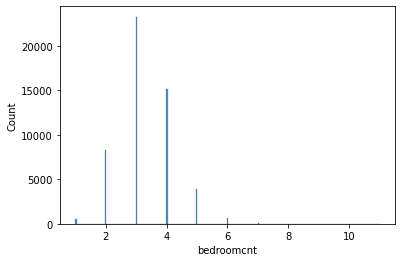

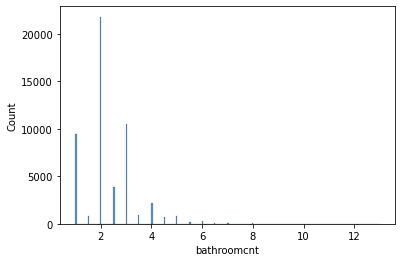

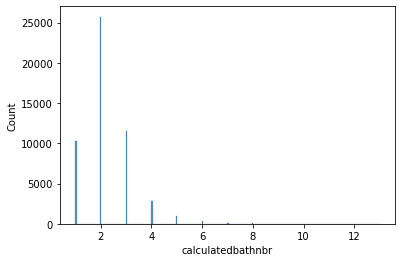

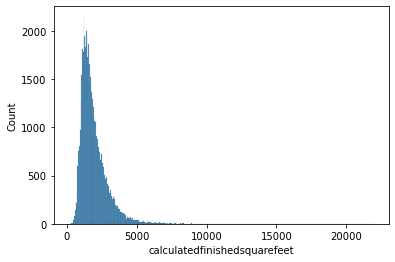

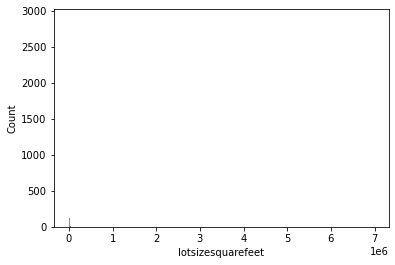

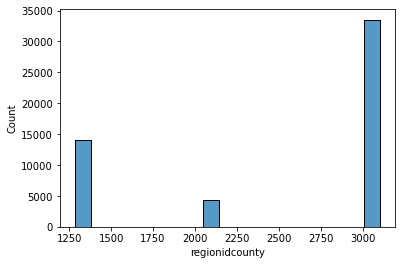

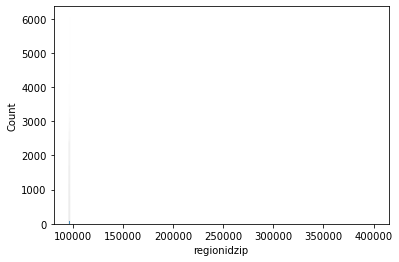

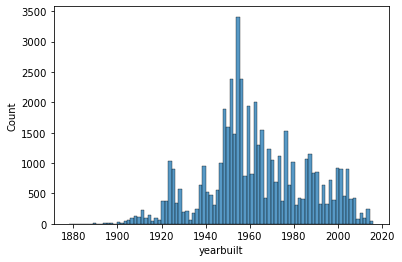

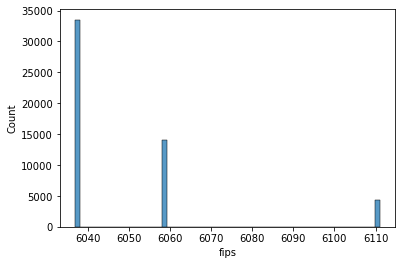

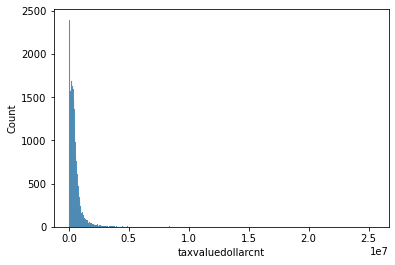

In [16]:
for column in df.columns.tolist():
    sns.histplot(data = df, x = column)
    plt.show()

<AxesSubplot:xlabel='lotsizesquarefeet', ylabel='Count'>

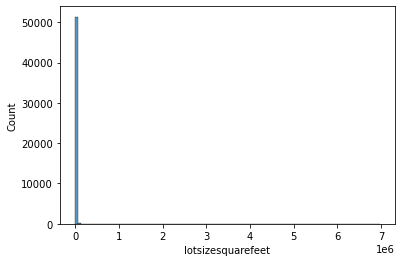

In [106]:
# There are some major outliers apparently in lotsizesquarefeet, so I want to visualize this better

sns.histplot(data = df, x ='lotsizesquarefeet', bins=100)

In [107]:
df.lotsizesquarefeet.sort_values(ascending=False).head(20)

1496     6971010.0
11444    6971010.0
9788     6971010.0
47049    6971010.0
37514    6971010.0
20605    6971010.0
18562    6971010.0
41688    2831752.0
45635    2562259.0
42974    1774617.0
9496     1746019.0
19692    1323788.0
26374    1111919.0
8085      941333.0
8086      941333.0
19741     889495.0
19338     872645.0
19604     872158.0
15560     862329.0
34810     766570.0
Name: lotsizesquarefeet, dtype: float64

Seeing the above number it looks like some of these values are outliers. I am going to make the determination to set an upper limit of 300,000 for lotsizesquarefeet which is about 6.9 acres.

In [108]:
df = df[df.lotsizesquarefeet < 300000]

In [109]:
df.shape

(51790, 10)

Now looking at taxvaluedollarcnt outliers

In [110]:
df.taxvaluedollarcnt.sort_values(ascending=False).head(50)

11424    25381250.0
6371     24345695.0
23697    23858374.0
32208    22589311.0
51314    20203475.0
7904     19280700.0
28653    18812604.0
3119     16814671.0
9475     16497812.0
51087    15736374.0
23259    15623925.0
41050    15618488.0
43576    15533020.0
22293    13852918.0
50689    13600098.0
11767    13198250.0
18053    13191321.0
29982    13128583.0
50569    12479401.0
2205     12427324.0
17069    12386870.0
11814    12081475.0
30638    11317682.0
36959    11020600.0
43263    11000000.0
40739    10873908.0
4716     10610405.0
51327    10355345.0
42921    10152678.0
23394    10130485.0
27521    10071018.0
51040    10050974.0
44912     9935000.0
34607     9870514.0
12914     9837579.0
42738     9837578.0
49399     9523337.0
14898     9467005.0
23511     9323011.0
5252      9283780.0
45782     9177942.0
23089     9120827.0
35105     8946027.0
49668     8868009.0
28699     8823765.0
6677      8765700.0
2263      8529934.0
21086     8400047.0
49678     8397673.0
31030     8387524.0


Deciding to set the upper limit on taxvaluedollarcnt at 4 million as that will take care a large number of outliers.

<AxesSubplot:xlabel='taxvaluedollarcnt', ylabel='Count'>

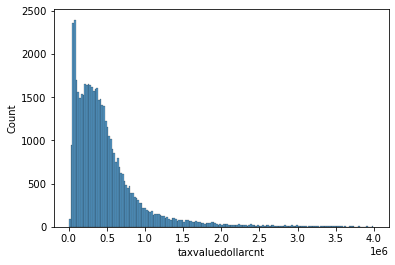

In [111]:
sns.histplot(data = df[df.taxvaluedollarcnt < 4000000], x = 'taxvaluedollarcnt')

In [112]:
df = df[df.taxvaluedollarcnt < 4000000]

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51496 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51496 non-null  float64
 1   bathroomcnt                   51496 non-null  float64
 2   calculatedbathnbr             51496 non-null  float64
 3   calculatedfinishedsquarefeet  51496 non-null  float64
 4   lotsizesquarefeet             51496 non-null  float64
 5   regionidcounty                51496 non-null  float64
 6   regionidzip                   51496 non-null  float64
 7   yearbuilt                     51496 non-null  float64
 8   fips                          51496 non-null  float64
 9   taxvaluedollarcnt             51496 non-null  float64
dtypes: float64(10)
memory usage: 4.3 MB


Now investigating the calculatedfinishedsquarefeet.

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='Count'>

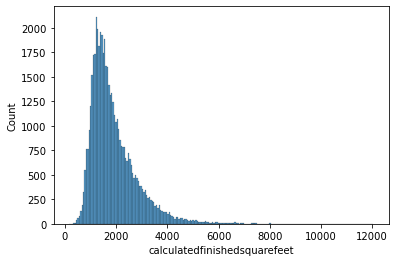

In [114]:
sns.histplot(data = df, x = 'calculatedfinishedsquarefeet')

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='Count'>

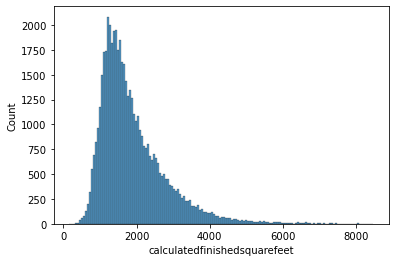

In [115]:
sns.histplot(data = df[df.calculatedfinishedsquarefeet < 8500], x = 'calculatedfinishedsquarefeet')

In [116]:
df[df.calculatedfinishedsquarefeet < 8500].shape

(51475, 10)

In [117]:
df = df[df.calculatedfinishedsquarefeet < 8500]

Deciding to set the upper limit on calculatedfinishedsquarefeet at 8500 as that will take care a large number of outliers and make the model more applicable to the majority of homes.

Making a function which gets rid of nonsense home sizes.`

In [118]:
def minimum_sqr_ft(df):
    '''
    Function that takes in a dataframe and finds the minimum sq footage necessary given an input number of bathrooms and bedrooms.
    
    Returns a total minimum amount
    '''
    # min square footage for type of room
    bathroom_min = 10
    bedroom_min = 70
    
    # total MIN sqr feet
    total = (df.bathroomcnt * bathroom_min) + (df.bedroomcnt * bedroom_min)
    # return MIN sqr feet
    return total

def clean_sqr_feet(df):
    '''
    Takes in a dataframe finds the theoretical minimum sq footage given bathroom and bedroom inputs and compares that to the actual
    given sq footage.  
    Returns a dataframe where containing results only having an actual sq footage larger than the calculate minimum.
    '''
    # get MIN sqr ft
    min_sqr_ft = minimum_sqr_ft(df)
    # return df with sqr_ft >= min_sqr_ft
    # change 'sqr_ft' to whichever name you have for sqr_ft in df
    return df[df.calculatedfinishedsquarefeet >= min_sqr_ft]



In [119]:
df = clean_sqr_feet(df)

In [120]:
df.shape

(51474, 10)

Creating a function that maps actual county names to the dataset instead of having fip numbers.

In [121]:
def map_counties(df):
    # identified counties for fips codes 
    counties = {6037: 'los_angeles',
                6059: 'orange',
                6111: 'ventura'}
    # map counties to fips codes
    df.fips = df.fips.map(counties)
    df.rename(columns=({ 'fips': 'county'}), inplace=True)
    return df

In [122]:
df = map_counties(df)

In [123]:
df.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidcounty,regionidzip,yearbuilt,county,taxvaluedollarcnt
0,4.0,3.0,3.0,2123.0,7310.0,1286.0,96978.0,1959.0,orange,569452.0
1,3.0,2.0,2.0,1230.0,4142.0,3101.0,96046.0,1926.0,los_angeles,29770.0
2,2.0,1.0,1.0,600.0,7043.0,1286.0,97003.0,1948.0,orange,234307.0
3,4.0,2.0,2.0,1463.0,7519.0,3101.0,96342.0,1957.0,los_angeles,109437.0
4,4.0,2.5,2.0,2184.0,8569.0,2061.0,96383.0,1978.0,ventura,713482.0


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51474 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51474 non-null  float64
 1   bathroomcnt                   51474 non-null  float64
 2   calculatedbathnbr             51474 non-null  float64
 3   calculatedfinishedsquarefeet  51474 non-null  float64
 4   lotsizesquarefeet             51474 non-null  float64
 5   regionidcounty                51474 non-null  float64
 6   regionidzip                   51474 non-null  float64
 7   yearbuilt                     51474 non-null  float64
 8   county                        51474 non-null  object 
 9   taxvaluedollarcnt             51474 non-null  float64
dtypes: float64(9), object(1)
memory usage: 4.3+ MB


In [125]:
df.bedroomcnt = df.bedroomcnt.astype('uint8')
df.bathroomcnt = df.bathroomcnt.astype('float16')
df.calculatedbathnbr = df.calculatedbathnbr.astype('float16')
df.yearbuilt = df.yearbuilt.astype('uint16')
df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.astype('uint16')

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51474 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51474 non-null  uint8  
 1   bathroomcnt                   51474 non-null  float16
 2   calculatedbathnbr             51474 non-null  float16
 3   calculatedfinishedsquarefeet  51474 non-null  uint16 
 4   lotsizesquarefeet             51474 non-null  float64
 5   regionidcounty                51474 non-null  float64
 6   regionidzip                   51474 non-null  float64
 7   yearbuilt                     51474 non-null  uint16 
 8   county                        51474 non-null  object 
 9   taxvaluedollarcnt             51474 non-null  float64
dtypes: float16(2), float64(4), object(1), uint16(2), uint8(1)
memory usage: 2.8+ MB


Final dataset is 51474 entries which is 98.2% of the original 52441 entries which existed before cleaning.

# Data Preparation

In [83]:
# scaler
from sklearn.preprocessing import MinMaxScaler
# train test split from sklearn
from sklearn.model_selection import train_test_split

Creating functions to prepare the dataset for EDA.

In [127]:
def split_zillow(df):
    '''
    Takes in a cleaned zillow dataframe, splits it into train, validate and test subgroups and then returns those subgroups.
    
    Arguments: df - a cleaned pandas dataframe with the expected feature names and columns in the zillow dataset
    Return: train, validate, test - dataframes ready for the exploration and model phases.
    '''
    train, test = train_test_split(df, train_size = 0.8, random_state = 1234)
    train, validate = train_test_split(train, train_size = 0.7, random_state = 1234)
    return train, validate, test

def data_scaler(train, validate, test, columns_to_scale):
    '''
    This function takes in train, validate, test subsets of the cleaned zillow dataset and using the train subset creates a min_max 
    scaler. It thens scales the subsets and returns the train, validate, test subsets as scaled versions of the initial data.

    Arguments:  train, validate, test - split subsets from of the cleaned zillow dataframe
                columns_to_scale - a list of column names to scale
    Return: scaled_train, scaled_validate, scaled_test - dataframe with scaled versions of the initial unscaled dataframes 
    '''
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = MinMaxScaler()
    
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.fit_transform(train[columns_to_scale]), 
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])

    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])

    return train_scaled, validate_scaled, test_scaled

In [128]:
train, validate, test = split_zillow(df)

In [129]:
train.shape, validate.shape, test.shape

((28825, 10), (12354, 10), (10295, 10))

In [130]:
train.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidcounty,regionidzip,yearbuilt,county,taxvaluedollarcnt
23156,2,2.0,2.0,1538,8370.0,3101.0,96424.0,1938,los_angeles,102269.0
2568,4,2.0,2.0,1176,6096.0,3101.0,96464.0,1954,los_angeles,324566.0
21142,4,3.5,3.0,2288,2920.0,1286.0,97035.0,2004,orange,709000.0
697,3,2.0,2.0,1603,5859.0,3101.0,96111.0,1947,los_angeles,351733.0
24151,3,2.5,2.0,2463,7306.0,2061.0,97084.0,2004,ventura,610000.0


Train subset ready for EDA. This is the same data as below in the train_scaled subset but not scaled as to make EDA easier to do.

In [131]:
train_scaled, validate_scaled, test_scaled = data_scaler(train, validate, test, columns_to_scale=(df.drop(columns = ['county', 'taxvaluedollarcnt']).columns))

In [132]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((28825, 10), (12354, 10), (10295, 10))

In [133]:
train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidcounty,regionidzip,yearbuilt,county,taxvaluedollarcnt
23156,0.125,0.1250,0.125,0.151623,0.027058,1.000000,0.001455,0.434783,los_angeles,102269.0
2568,0.375,0.1250,0.125,0.107287,0.019260,1.000000,0.001587,0.550725,los_angeles,324566.0
21142,0.375,0.3125,0.250,0.243478,0.008368,0.000000,0.003467,0.913043,orange,709000.0
697,0.250,0.1250,0.125,0.159584,0.018447,1.000000,0.000425,0.500000,los_angeles,351733.0
24151,0.250,0.1875,0.125,0.264911,0.023409,0.426997,0.003629,0.913043,ventura,610000.0


Subsets train_scaled, validate_scaled, test_scaled ready for modeling after EDA is complete.

# Exploratory Data Analysis

My thoughts from before the data analysis.
- I'm pretty most of the features will be postively correlated in some way with the target. Though not all my be strong.
- I think lotsizesquarefeet and calculatedfinishedsquarefeet will have the strongest relationship with the target.
- I'm unsure how strongly bathroomcnt will correlate, but I suspet bedroomcnt will be relatively strong.
- I don't think regionidcounty and regionidzip will have any significant relationship with the target as these are actually categorical data in numerical form.

In [46]:
# Writing a function that plots pairs of continuous variables to visualize all the potential relationships.
from itertools import combinations

def plot_variable_pairs(df, to_drop = None):
    '''
    This function takes in a dataframe and plots all possible numerical data pairs in scatterplots with a regression 
    line. The function only plots unique combinations of pairs, not permutations, e.g. only prints column a by 
    column b, but leaves out column b by column a. This reduces clutter and runtime.
    
    arguments: df - A dataframe with numerical columns
               to_drop - a list of columns to drop or not include in the plots
    returns: This function returns nothing; it merely plots out the scatterplots
    '''
    
    if to_drop == None:
        columns_to_plot = df.select_dtypes(include = 'number').columns
        plot_tuples = []
        for i in combinations(columns_to_plot,2):
            plot_tuples.append(i)

        for i in plot_tuples:
            sns.lmplot(x = i[0], y = i[1], data = df, line_kws={'color': '#FF5E13', 'linewidth': 3},  height=5, aspect=1.5)
            plt.plot()
            plt.show()
    else:
        columns_to_plot = df.select_dtypes(include = 'number').columns.drop(to_drop)
        plot_tuples = []
        for i in combinations(columns_to_plot,2):
            plot_tuples.append(i)

        for i in plot_tuples:
            sns.lmplot(x = i[0], y = i[1], data = df, line_kws={'color': '#FF5E13', 'linewidth': 3},  height=5, aspect=1.5)
            plt.plot()
            plt.show()

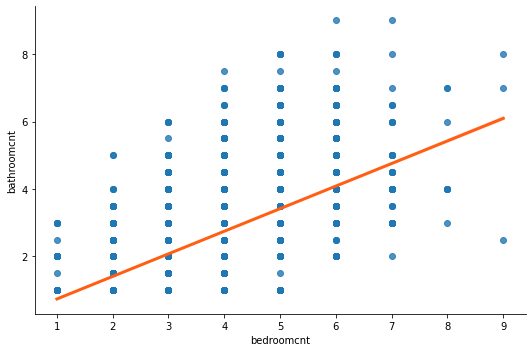

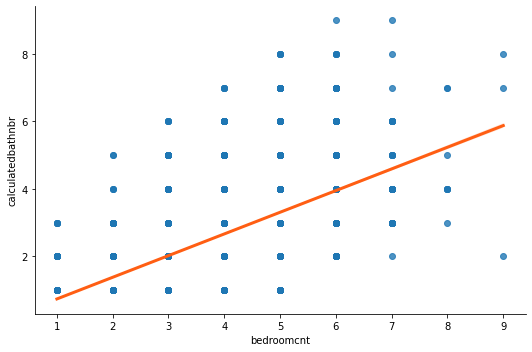

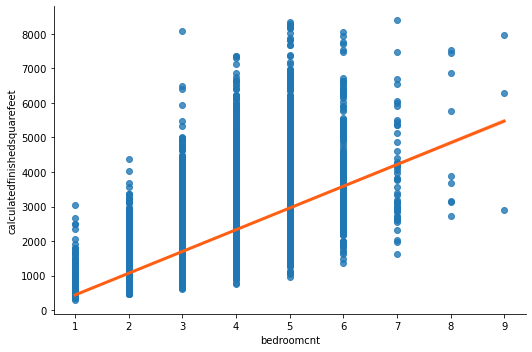

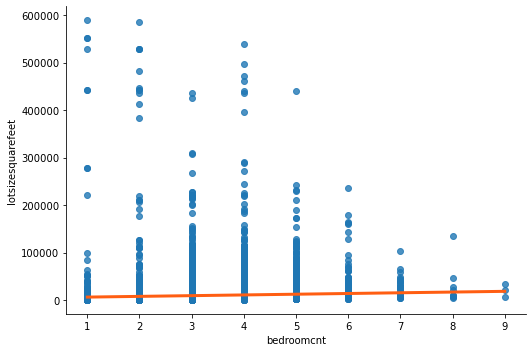

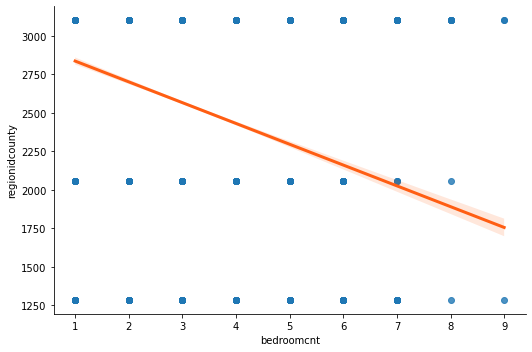

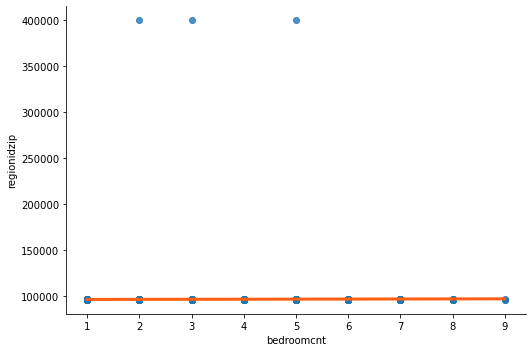

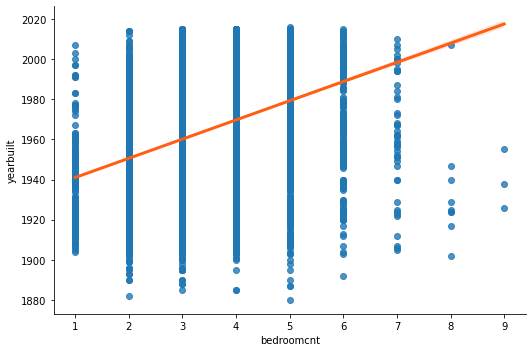

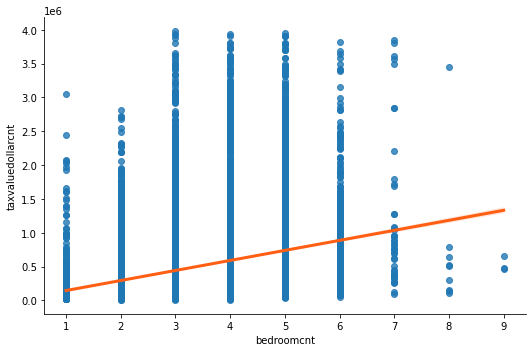

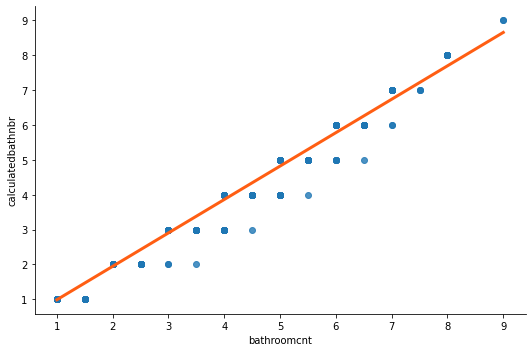

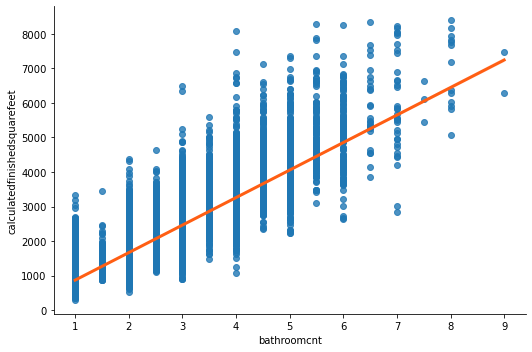

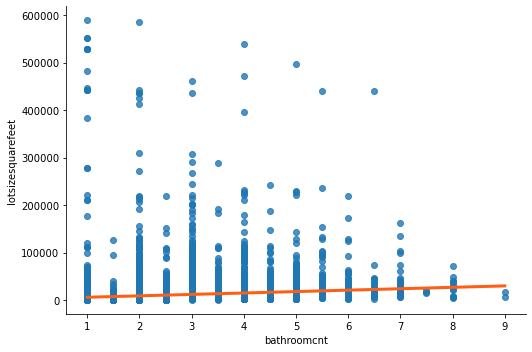

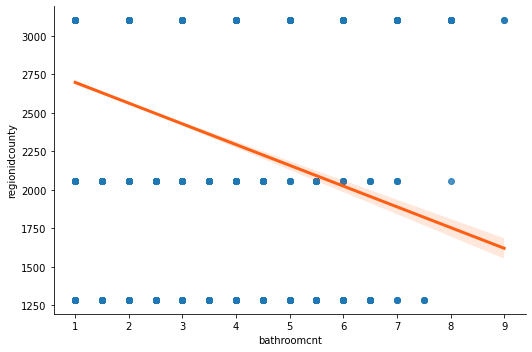

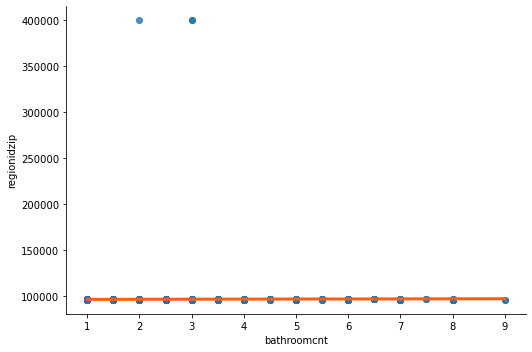

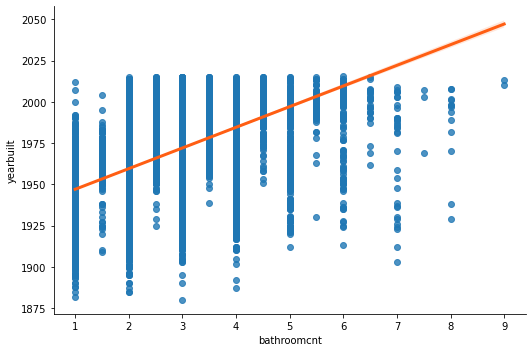

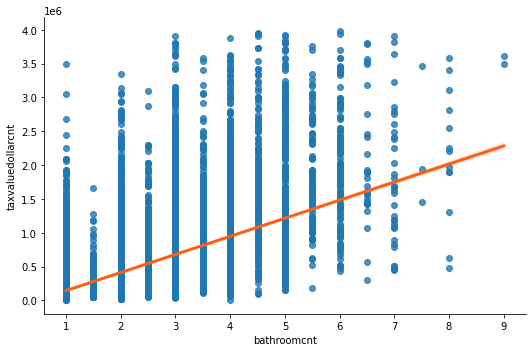

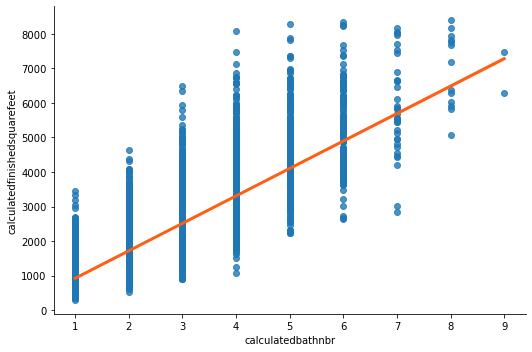

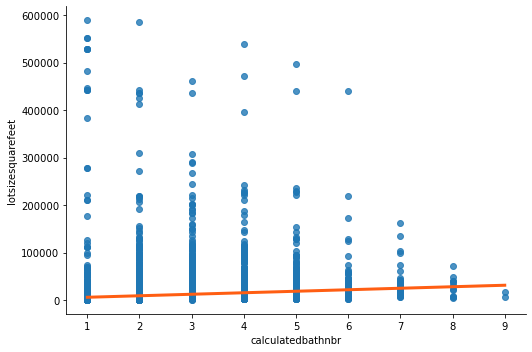

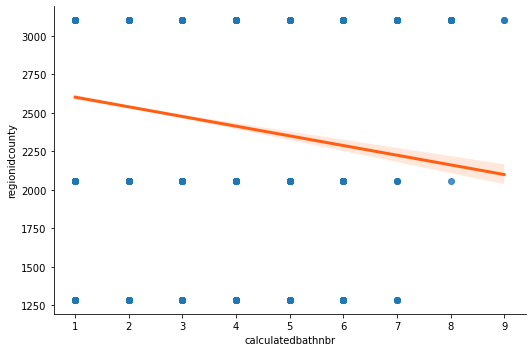

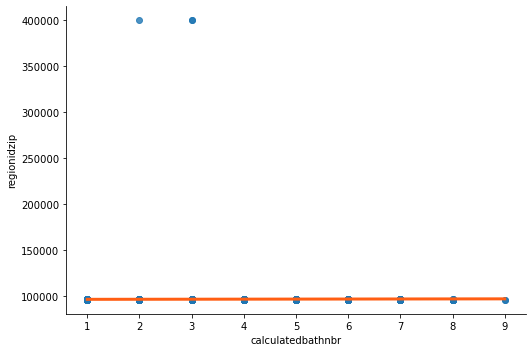

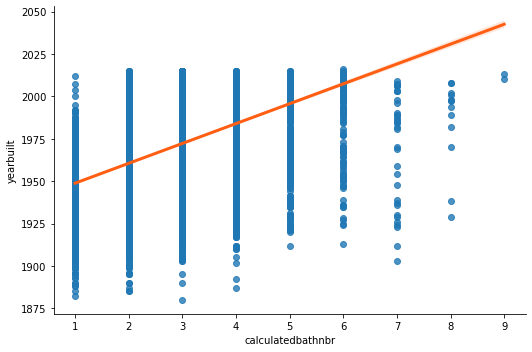

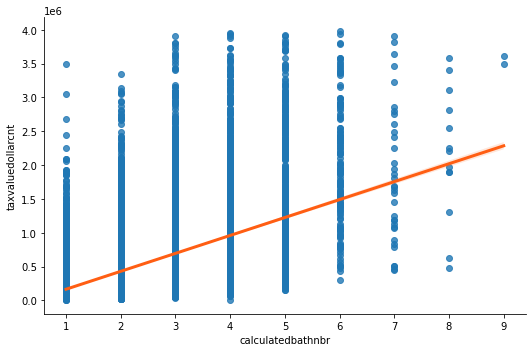

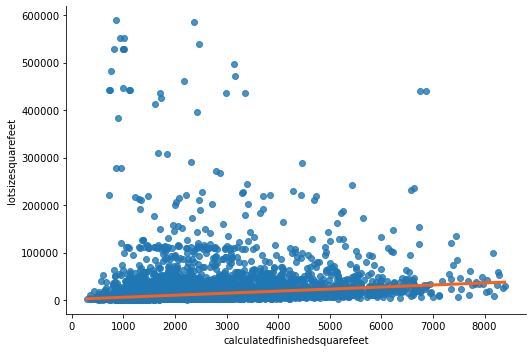

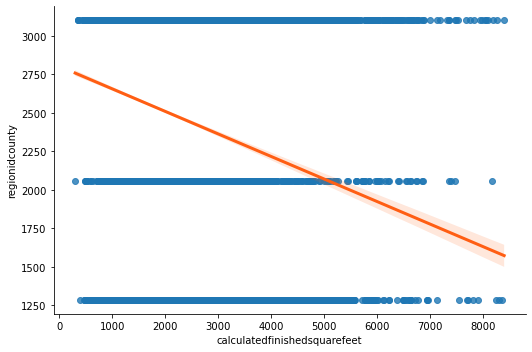

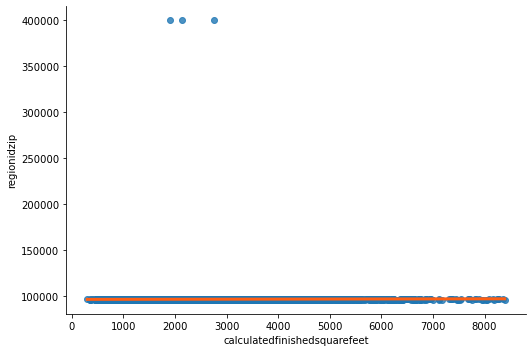

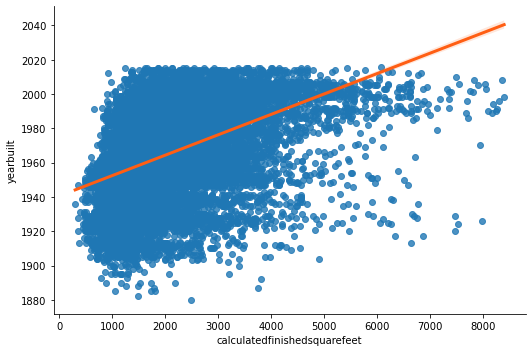

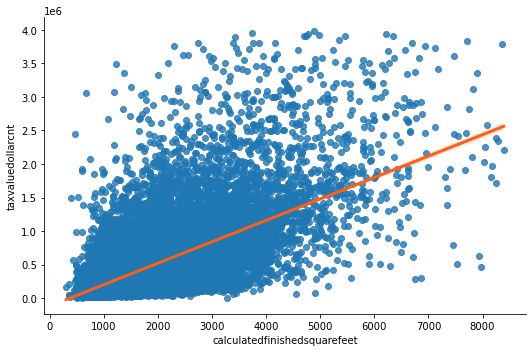

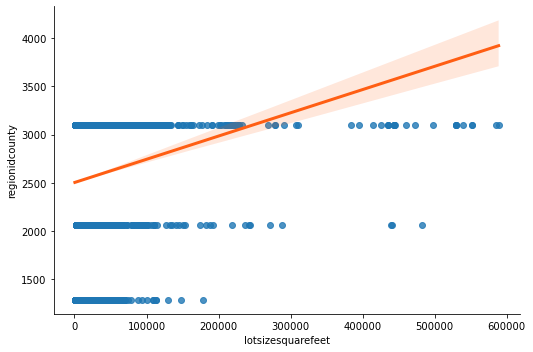

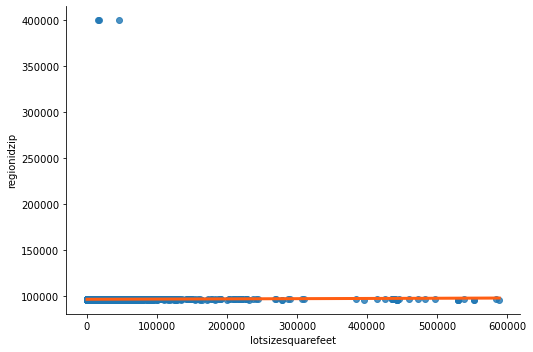

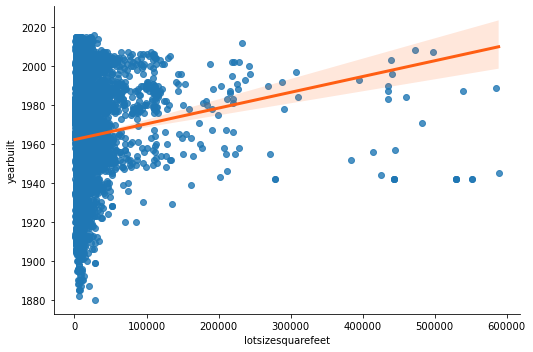

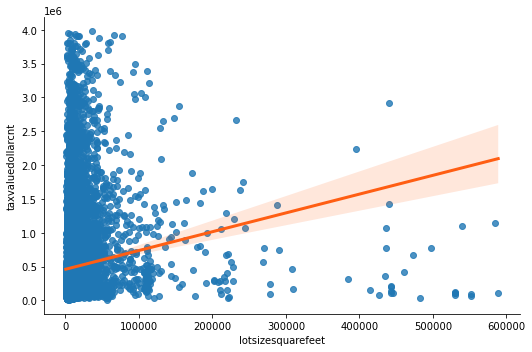

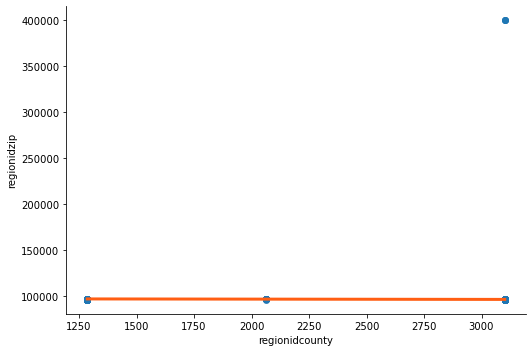

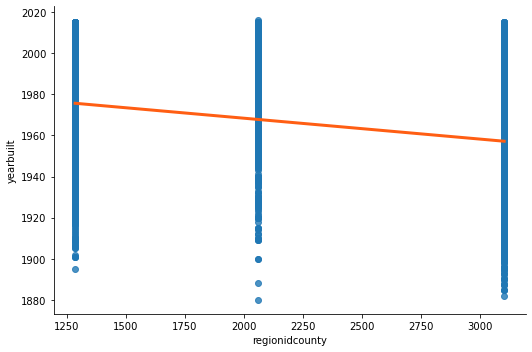

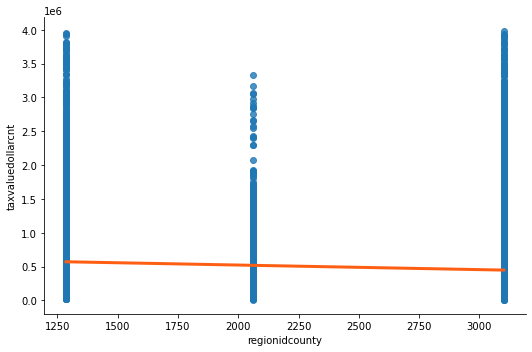

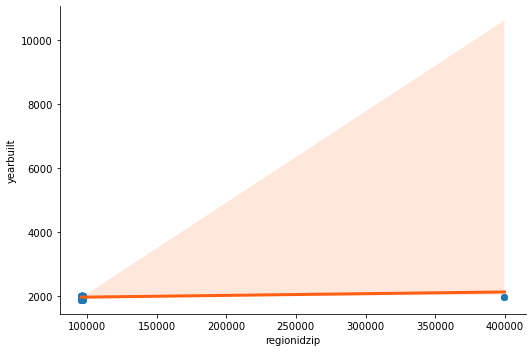

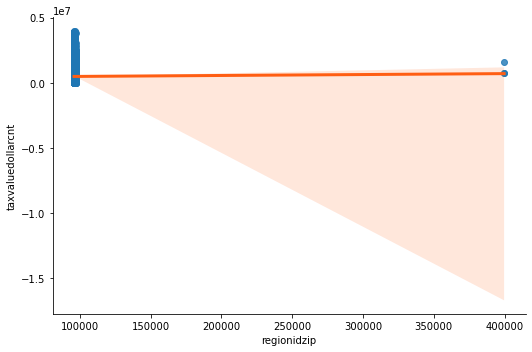

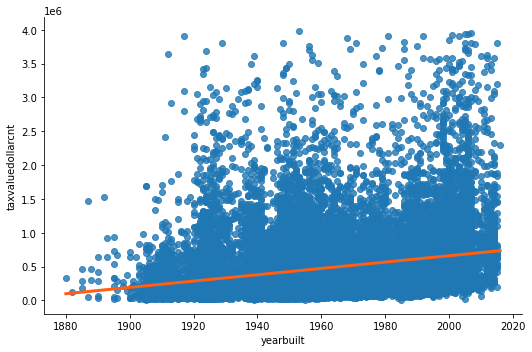

In [47]:
plot_variable_pairs(train)

In [91]:
# # Writing a function that plots continuous variables with categoricals separated out to visualize all the potential relationships.

def plot_categorical_and_continuous_vars(df, continuous, categorical):
    '''
    This function takes in a dataframe, a list of continuous variables, and a list of categorical variables and does 
    3 plots for each unique combination of categorical and continuous variable.
    
    Arguments: df - a dataframe consisting of continuous and categorical columns
    '''
    plot_list = []
    for cat in categorical:
        for cont in continuous:
            plot_list.append([cat, cont])
    
    for i in plot_list:
        plt.figure(figsize=(18, 5))
        plt.subplot(131)
        sns.boxplot(x=i[0], y=i[1], data=df)
        plt.subplot(132)
        sns.stripplot(x=i[0], y=i[1], data=df)
        plt.subplot(133)
        sns.violinplot(x=i[0], y=i[1], data=df)
#         sns.barplot(x=i[0], y=i[1], data=df)
        plt.show()

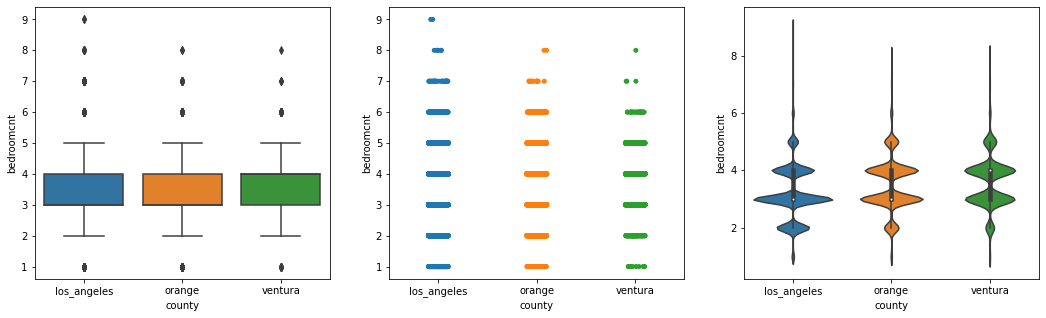

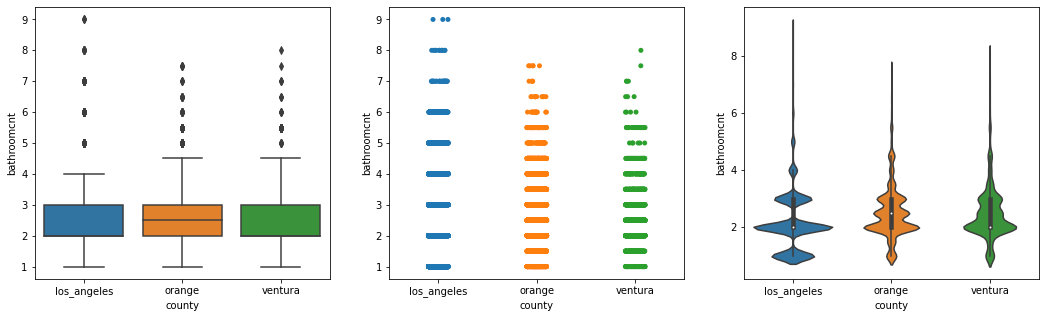

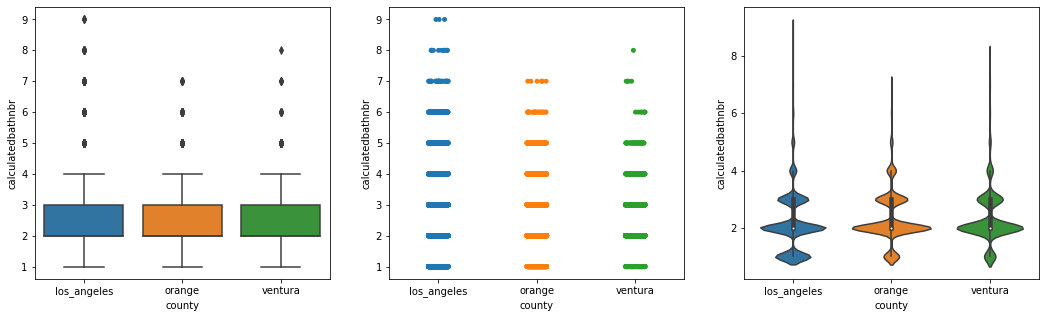

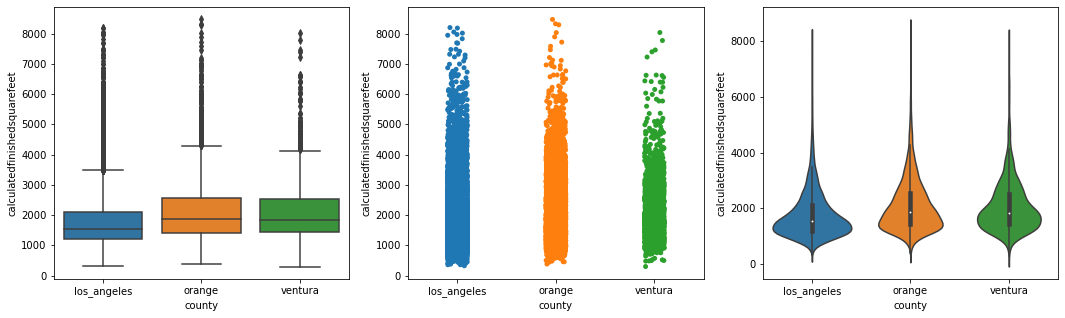

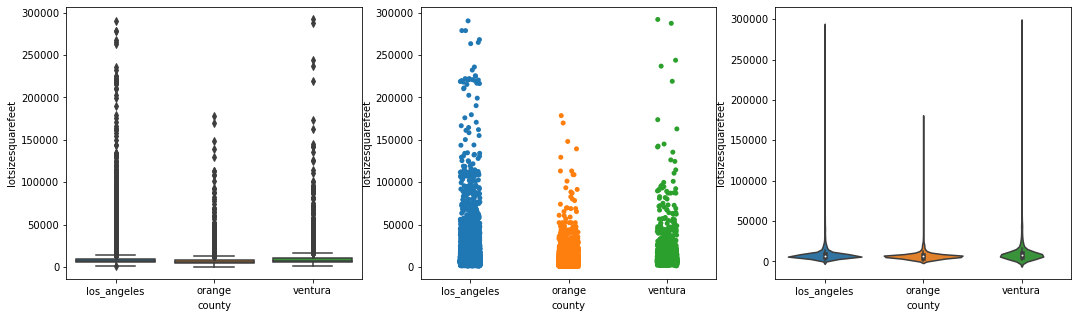

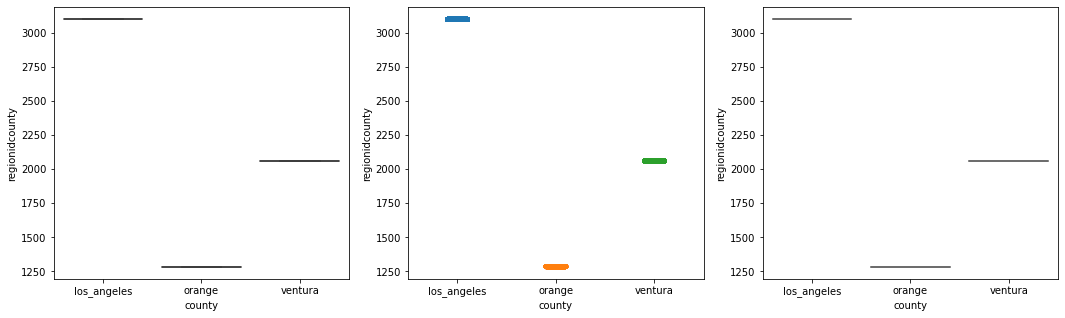

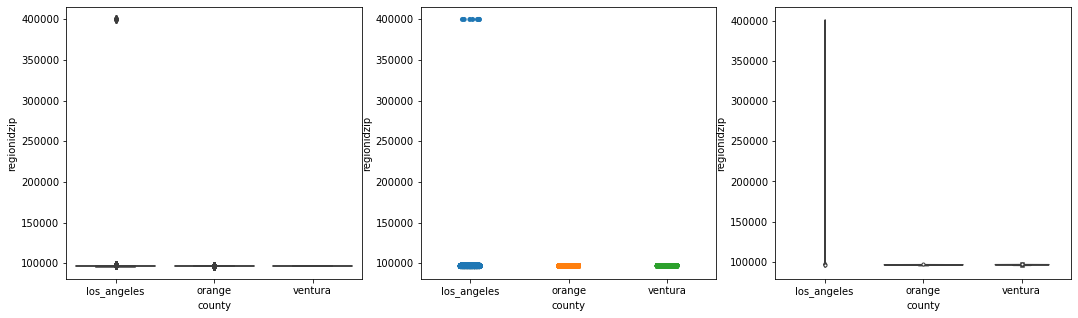

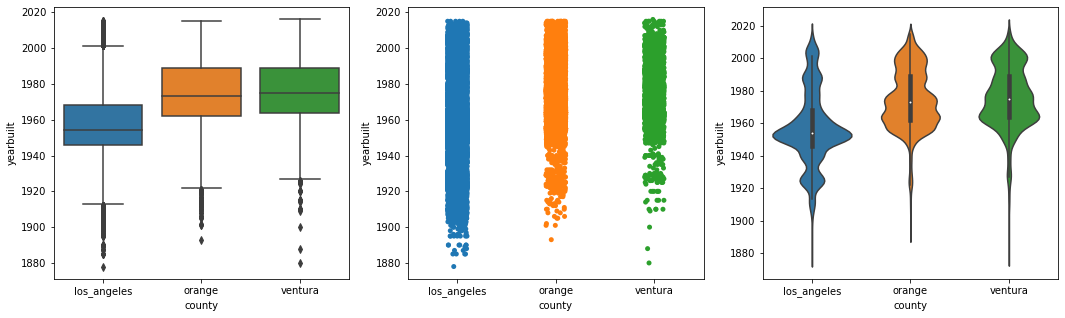

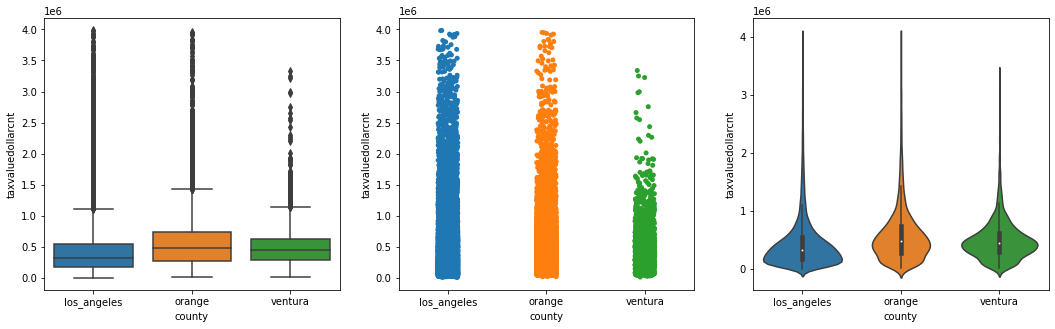

In [134]:
plot_categorical_and_continuous_vars(train, train.select_dtypes('number').columns, train.select_dtypes('object').columns)

Visualizing Individual data separated by county

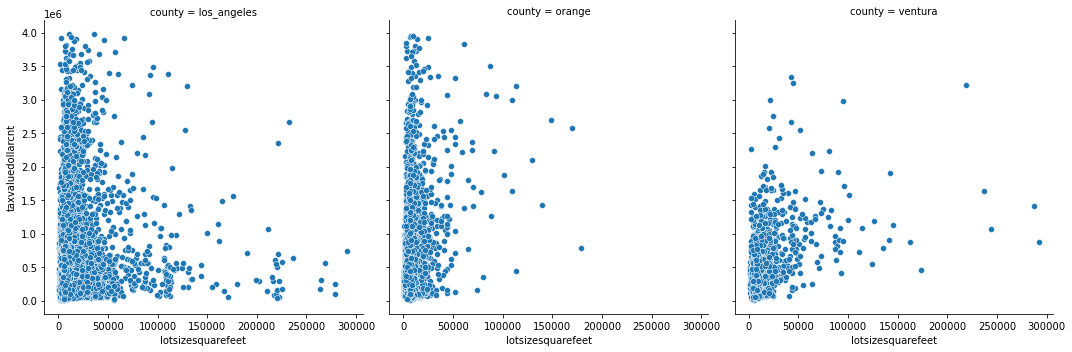

In [138]:
sns.relplot(x="lotsizesquarefeet", y="taxvaluedollarcnt", data=train,  kind='scatter', height=5, col='county')
plt.show()

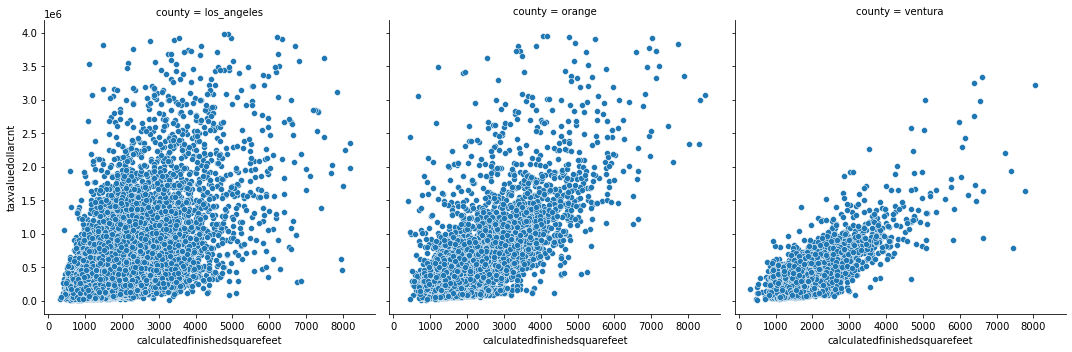

In [139]:
sns.relplot(x="calculatedfinishedsquarefeet", y="taxvaluedollarcnt", data=train,  kind='scatter', height=5, col='county')
plt.show()

Exploring correlations 

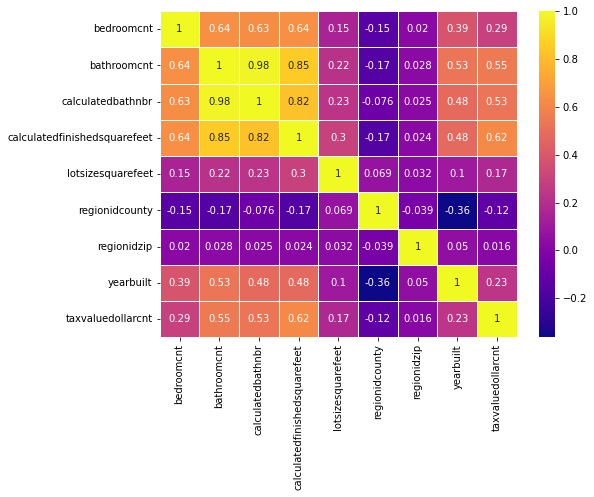

In [141]:
train_corr = train.drop(columns=['county']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(train_corr, cmap='plasma', annot=True, linewidth=0.5)

plt.show()

In [ ]:
Looking at this heatmap, I'm not super encouraged by the correlations I have here